In [3]:
!pip install -U "pip<25.3"
!pip install -U "numpy==1.26.4" \
               "pandas==2.2.2" \
               "matplotlib==3.8.4" \
               "pillow==10.3.0" \
               "scikit-learn==1.4.2" \
               "opencv-python==4.10.0.84"

Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-25.2-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.2-py3-none-any.whl (1.8 MB)



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\ProgramData\anaconda3\python.exe -m pip install -U pip<25.3


^C


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os, json, glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

# 그래프 한글 폰트 이슈가 있으면 주석 해제하고 시스템에 맞는 폰트를 지정하세요.
# import matplotlib
# matplotlib.rc('font', family='Malgun Gothic')  # 윈도우 '맑은 고딕'
# plt.rcParams['axes.unicode_minus'] = False


In [11]:
# 🔤 Matplotlib 한글 폰트 설정 (Windows/Mac/Linux 자동 시도)
import os, sys
import matplotlib
from matplotlib import font_manager, rcParams

def set_korean_font():
    candidates = [
        # Windows
        ("Malgun Gothic", r"C:\Windows\Fonts\malgun.ttf"),
        # macOS
        ("AppleGothic", "/System/Library/Fonts/AppleGothic.ttf"),
        # Linux (설치되어 있으면)
        ("NanumGothic", "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"),
        ("Noto Sans CJK KR", "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"),
        ("Noto Sans KR", "/usr/share/fonts/truetype/noto/NotoSansKR-Regular.otf"),
    ]

    chosen = None
    for name, path in candidates:
        if os.path.exists(path):
            try:
                font_manager.fontManager.addfont(path)
                rcParams["font.family"] = name
                chosen = (name, path)
                break
            except Exception:
                pass

    # 설치 경로를 못 찾았어도, 시스템에 이름만 등록되어 있을 수 있음
    if not chosen:
        for f in font_manager.findSystemFonts():
            if any(k in f.lower() for k in ["malgun", "applegothic", "nanum", "notosanscjk", "notosanskr"]):
                try:
                    font_manager.fontManager.addfont(f)
                    # 파일명에서 폰트 패밀리명 추정이 어려우니 DejaVu 대체로 설정
                    # → 가능하면 아래 줄을 원하는 폰트 이름으로 바꿔주세요.
                    rcParams["font.family"] = "DejaVu Sans"
                    chosen = ("(system)", f)
                    break
                except Exception:
                    pass

    # 그래프에서 음수 기호 깨짐 방지
    rcParams["axes.unicode_minus"] = False

    print("Font set to:", chosen or "fallback (DejaVu Sans)")

set_korean_font()


Font set to: ('Malgun Gothic', 'C:\\Windows\\Fonts\\malgun.ttf')


In [5]:
\
# ★★★ 여기만 확인/수정하세요 ★★★
# 윈도우의 실제 데이터 폴더
BASE_DIR = Path(r"C:\Users\USER\Downloads\korean_emotion_complex_vision_1_percent")

# 서브 폴더들 (변경하지 않아도 됨)
LABELS_DIR = BASE_DIR / "labels"                # JSON들이 들어있는 폴더
EMOTION_DIR = BASE_DIR                           # 감정별 이미지 폴더들이 바로 아래에 있음 (중립/슬픔/상처/불안/분노/당황/기쁨)
PROCESSED_DIR = BASE_DIR / "processed"           # 전처리 결과 저장 폴더(자동 생성)
(PROCESSED_DIR / "from_json").mkdir(parents=True, exist_ok=True)
(PROCESSED_DIR / "from_folders").mkdir(parents=True, exist_ok=True)

BASE_DIR, LABELS_DIR, EMOTION_DIR, PROCESSED_DIR


(WindowsPath('C:/Users/USER/Downloads/korean_emotion_complex_vision_1_percent'),
 WindowsPath('C:/Users/USER/Downloads/korean_emotion_complex_vision_1_percent/labels'),
 WindowsPath('C:/Users/USER/Downloads/korean_emotion_complex_vision_1_percent'),
 WindowsPath('C:/Users/USER/Downloads/korean_emotion_complex_vision_1_percent/processed'))

### 1) JSON 파일 목록 확인

In [6]:
json_files = sorted(glob.glob(str(LABELS_DIR / "*_sampled.json")))
json_files


['C:\\Users\\USER\\Downloads\\korean_emotion_complex_vision_1_percent\\labels\\기쁨_sampled.json',
 'C:\\Users\\USER\\Downloads\\korean_emotion_complex_vision_1_percent\\labels\\당황_sampled.json',
 'C:\\Users\\USER\\Downloads\\korean_emotion_complex_vision_1_percent\\labels\\분노_sampled.json',
 'C:\\Users\\USER\\Downloads\\korean_emotion_complex_vision_1_percent\\labels\\불안_sampled.json',
 'C:\\Users\\USER\\Downloads\\korean_emotion_complex_vision_1_percent\\labels\\상처_sampled.json',
 'C:\\Users\\USER\\Downloads\\korean_emotion_complex_vision_1_percent\\labels\\슬픔_sampled.json',
 'C:\\Users\\USER\\Downloads\\korean_emotion_complex_vision_1_percent\\labels\\중립_sampled.json']

### 2) 다양한 구조(JSON 리스트/COCO)를 안전하게 읽어 `DataFrame`으로 합치기

In [7]:
def parse_json_to_rows(json_path: Path, default_label=None):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    rows = []
    # COCO-like
    if isinstance(data, dict) and 'annotations' in data and 'images' in data:
        imgs = {img['id']: img for img in data['images']}
        categories = {c['id']: c.get('name', c['id']) for c in data.get('categories', [])}
        for a in data['annotations']:
            img = imgs.get(a['image_id'], {})
            rows.append({
                'file_name': img.get('file_name'),
                'label': categories.get(a.get('category_id')) or default_label,
                'bbox': a.get('bbox')
            })
    # simple list
    elif isinstance(data, list):
        for e in data:
            rows.append({
                'file_name': e.get('image') or e.get('file_name') or e.get('filename'),
                'label': e.get('label') or e.get('emotion') or default_label,
                'bbox': e.get('bbox')
            })
    else:
        print(f"[경고] 지원하지 않는 구조: {json_path.name}")
    return rows

all_rows = []
for jp in json_files:
    # 파일명에서 감정명 추출 (예: '기쁨_sampled.json' → '기쁨')
    default_label = Path(jp).stem.replace("_sampled","")
    all_rows.extend(parse_json_to_rows(Path(jp), default_label=default_label))

df = pd.DataFrame(all_rows)
df.head()


,file_name,label,bbox
0,5a30dc193e2c6144184968043c00773270b111a23a3c83...,기쁨,None
1,0d18ae1ed7d9e912864b736523a94a24db0595bf273964...,기쁨,None
2,8f7e2f5214659c45cdcbc99a4e9ec29cf0b7571844a28e...,기쁨,None
3,2964f04ec5e9bcc45276def3a6e08a3c2d1418995cf31f...,기쁨,None
4,5feb258aabe4308f740ab36c133ef854074b138dcad3d6...,기쁨,None


### 3) 라벨 분포 보기

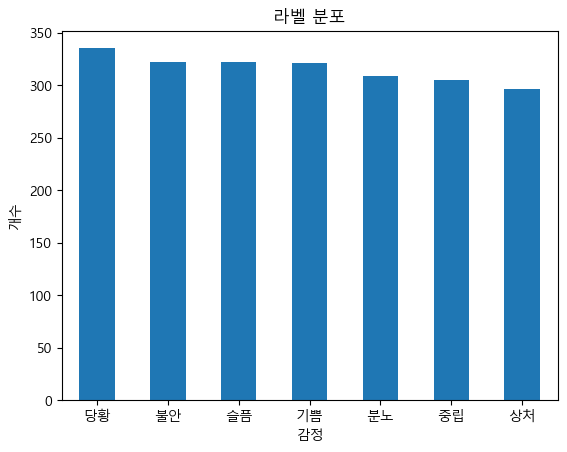

In [13]:
label_counts.plot(kind='bar')
plt.title('라벨 분포')
plt.xlabel('감정')
plt.ylabel('개수')
plt.xticks(rotation=0)  # x축 글씨 각도 0도로 설정 → 가로쓰기
plt.show()


### 4) 이미지 경로 존재 여부 및 bbox 면적 통계

In [9]:
def exists_rel(fname):
    if not fname: return False
    p = (EMOTION_DIR / fname) if not Path(fname).is_absolute() else Path(fname)
    return p.exists()

df['exists'] = df['file_name'].apply(exists_rel)

def bbox_area(b):
    try:
        x,y,w,h = b
        return float(w) * float(h)
    except:
        return None

df['bbox_area'] = df['bbox'].apply(bbox_area)

display(df['exists'].value_counts())
df['bbox_area'].describe()


exists
False    2210
Name: count, dtype: int64

count       0
unique      0
top       NaN
freq      NaN
Name: bbox_area, dtype: object

### 5) 결과 테이블 CSV 저장 (선택)

In [10]:
out_csv = BASE_DIR / "labels_eda_table.csv"
df.to_csv(out_csv, index=False)
out_csv


WindowsPath('C:/Users/USER/Downloads/korean_emotion_complex_vision_1_percent/labels_eda_table.csv')